In [28]:
import numpy as np
import json
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Concatenate, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, Callback

Iteration=25000
lr=0.001
train_size = 0.9
# Load node data (25 nodes, 3 features: x, y, z)
with open("nodexy.txt", "r") as file:
    NodeOriginal = json.load(file)
NodeOriginal = np.array(NodeOriginal)  # Convert to NumPy array

# Load element data (features for each sample)
with open("thickness.txt", "r") as file:
    element_features = json.load(file)
element_features = np.array(element_features)  # Convert to NumPy array

# Load target values
energy = np.loadtxt("energy_absorbed.txt")
energy = np.array(energy).reshape(-1, 1)  # Ensure correct shape

# Extract x, y coordinates
NodeOriginal_x = NodeOriginal[:, :, 0]  # Extract all x-coordinates
NodeOriginal_y = NodeOriginal[:, :, 1]  # Extract all y-coordinates

# Identify and remove edge nodes (x or y = 0 or 30)
_, EdgeNodes = np.where((NodeOriginal_x == 0) | (NodeOriginal_x == 30) | (NodeOriginal_y == 0) | (NodeOriginal_y == 30))
EdgeNodes = np.unique(EdgeNodes)  # Get unique node indices to remove

# Create a mask and filter out edge nodes
mask = np.ones(25, dtype=bool)
mask[EdgeNodes] = False
filtered_nodes = NodeOriginal[:, :, :]  # Shape (samples, remaining_nodes, 3)

# Reshape node data into a structured 5x5 grid (each sample separately)
grid_data_list = []
for sample in filtered_nodes:
    node_positions = sample[:, :2]  # Extract (x, y)
    sorted_indices = np.lexsort((node_positions[:, 0], -node_positions[:, 1]))  # Sort by y (desc), then x (asc)
    sorted_nodes = sample[sorted_indices]  # Reorder nodes spatially
    grid_data = sorted_nodes.reshape(5, 5, 3)  # Convert into 5x5 grid
    grid_data_list.append(grid_data)

# Convert list to NumPy array (samples, 5, 5, 3)
node_grid_data = np.array(grid_data_list)

# Normalize data
from sklearn.preprocessing import MinMaxScaler

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
scaler_z = MinMaxScaler()

node_grid_data[:, :, :, 0] = scaler_x.fit_transform(node_grid_data[:, :, :, 0].reshape(-1, 1)).reshape(node_grid_data.shape[:3])
node_grid_data[:, :, :, 1] = scaler_y.fit_transform(node_grid_data[:, :, :, 1].reshape(-1, 1)).reshape(node_grid_data.shape[:3])
node_grid_data[:, :, :, 2] = scaler_z.fit_transform(node_grid_data[:, :, :, 2].reshape(-1, 1)).reshape(node_grid_data.shape[:3])

element_scaler = MinMaxScaler()
element_features = element_scaler.fit_transform(element_features)

energy_scaler = MinMaxScaler()
energy = energy_scaler.fit_transform(energy)

# Split data into training and testing sets
from sklearn.model_selection import train_test_split

X_train_nodes, X_test_nodes, X_train_elements, X_test_elements, y_train, y_test = train_test_split(
    node_grid_data, element_features, energy, test_size=1 - train_size, random_state=42
)

# Define CNN model for node features
node_input = Input(shape=(5, 5, 3), name="Node_Input")
node_branch = Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same")(node_input)
node_branch = MaxPooling2D(pool_size=(2, 2))(node_branch)
node_branch = Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same")(node_branch)
node_branch = Conv2D(filters=16, kernel_size=(3, 3), activation="relu", padding="same")(node_branch)
#node_branch = GlobalAveragePooling2D()(node_branch)  # Reduce to 1D
node_branch = Flatten()(node_branch)
# Define ANN model for element features
element_input = Input(shape=(X_train_elements.shape[1],), name="Element_Input")
element_branch = Dense(32, activation="swish")(element_input)
element_branch = Dropout(0.4)(element_branch)
element_branch = Dense(16, activation="swish")(element_branch)
element_branch = Dropout(0.2)(element_branch)
element_branch = Dense(16, activation="swish")(element_branch)
element_branch = Dense(8, activation="swish")(element_branch)

# Concatenate CNN and ANN features
merged = Concatenate()([node_branch, element_branch])
merged = Dense(16, activation="elu")(merged)
merged = Dense(8, activation="elu")(merged)
output = Dense(1, activation="linear", name="Prediction_Output")(merged)

# Create model
model = Model(inputs=[node_input, element_input], outputs=output)
#model=load_model("best_model.keras")
model.compile(optimizer=Adam(learning_rate=lr), loss="mse", metrics=["mae", "mse"])

# Define callbacks for early stopping and learning rate reduction
checkpoint = ModelCheckpoint("best_model.keras", monitor="mse", save_best_only=True, mode="min", verbose=0)
reduce_lr = ReduceLROnPlateau(monitor="val_mse", factor=0.8, patience=300, min_lr=1e-6, verbose=0)
class PrintMSECallback(Callback):
        def __init__(self, interval=1000):
            self.interval = interval

        def on_epoch_end(self, epoch, logs=None):
            if (epoch + 1) % self.interval == 0:  # Print every `interval` epochs
                mse = logs.get("loss")  # MSE is tracked as "loss" in model.fit()
                print(f"Epoch {epoch+1}: MAE = {mse:.10f}")
mse_callback = PrintMSECallback(interval=500)
# Train model
history = model.fit(
    [X_train_nodes, X_train_elements],
    y_train,
    epochs=Iteration,
    batch_size=1024,
    validation_split=0.1,
    callbacks=[checkpoint, reduce_lr, mse_callback],
    verbose=0
)

# Print final model summary
#model.summary()


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: MAE = 0.0196716581
Epoch 1000: MAE = 0.0093970364
Epoch 1500: MAE = 0.0027583721
Epoch 2000: MAE = 0.0013271243
Epoch 2500: MAE = 0.0005864628
Epoch 3000: MAE = 0.0004091880
Epoch 3500: MAE = 0.0003273455
Epoch 4000: MAE = 0.0002429837
Epoch 4500: MAE = 0.0002413886
Epoch 5000: MAE = 0.0001474759
Epoch 5500: MAE = 0.0001342790
Epoch 6000: MAE = 0.0001116320
Epoch 6500: MAE = 0.0001112730
Epoch 7000: MAE = 0.0001019867
Epoch 7500: MAE = 0.0000985323
Epoch 8000: MAE = 0.0000948993
Epoch 8500: MAE = 0.0000943722
Epoch 9000: MAE = 0.0000938534
Epoch 9500: MAE = 0.0000954015
Epoch 10000: MAE = 0.0000890682
Epoch 10500: MAE = 0.0000921472
Epoch 11000: MAE = 0.0000918657
Epoch 11500: MAE = 0.0000836527
Epoch 12000: MAE = 0.0000875445
Epoch 12500: MAE = 0.0000870065
Epoch 13000: MAE = 0.0000995793
Epoch 13500: MAE = 0.0000862416
Epoch 14000: MAE = 0.0000935888
Epoch 14500: MAE = 0.0000897516
Epoch 15000: MAE = 0.0000802809
Epoch 15500: MAE = 0.0000828884
Epoch 16000: MAE = 0.0000863

 Loaded best_model.keras successfully!
train samples:(1177, 1)
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
(1177, 1)


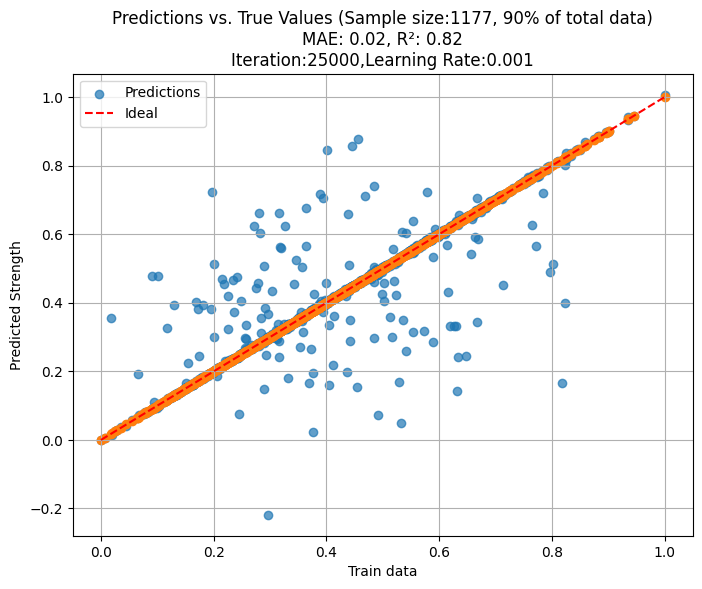

In [29]:
# Plot predictions vs. true values
from tensorflow.keras.models import  load_model
from sklearn.metrics import mean_absolute_error, r2_score
i=1
try:
    model = load_model("best_model.keras")
    print(" Loaded best_model.keras successfully!")
except:
    print(" No saved model found! Training from scratch.")
X_other_nodes,X_train_nodes,X_other_elements, X_train_elements,energy_test, energy_train = train_test_split(
        node_grid_data, element_features, energy, test_size=int(0.9*len(energy)), random_state=42)
print(f"train samples:{(energy_train).shape}")

y_pred = model.predict([X_train_nodes,X_train_elements])
print(y_pred.shape)
mae = mean_absolute_error(energy_train, y_pred)
r2 = r2_score(energy_train, y_pred)
plt.figure(figsize=(8, 6))
plt.scatter(energy_train, y_pred, alpha=0.7, label="Predictions")
plt.scatter(energy_train,energy_train)
plt.plot([min(energy_train), max(energy_train)], [min(energy_train), max(energy_train)], color="red", linestyle="--", label="Ideal")
plt.xlabel("Train data")
plt.ylabel("Predicted Strength")
plt.title(f"Predictions vs. True Values (Sample size:{int(i*0.9*len(energy))}, {round(i*0.9*100)}% of total data)\nMAE: {mae:.2f}, R²: {r2:.2f}\nIteration:{Iteration},Learning Rate:{lr}")
plt.legend()
plt.grid(True)
plt.show()

 Loaded saved model successfully!
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


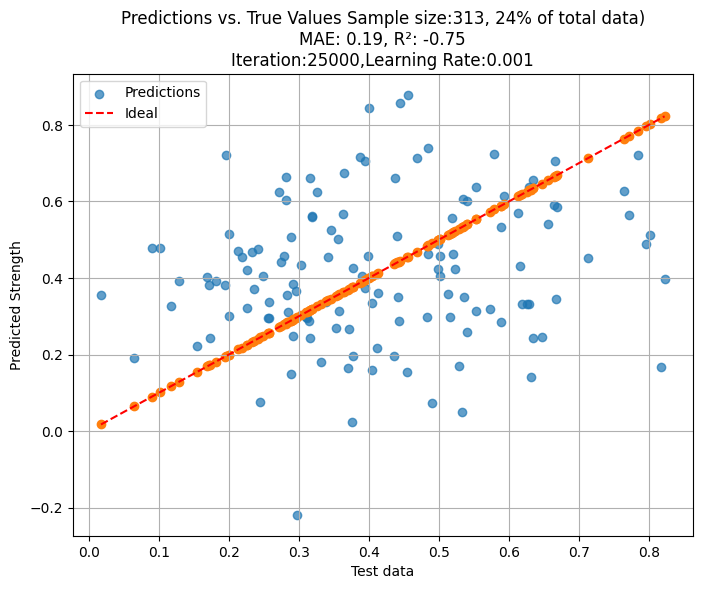

In [30]:
# Plot predictions vs. true values
try:
    model = load_model(f"best_model.keras")
    print(" Loaded saved model successfully!")
except:
    print(" No saved model found! Training from scratch.")

y_pred = model.predict([X_test_nodes, X_test_elements])
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, label="Predictions")
plt.scatter(y_test,y_test)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--", label="Ideal")
plt.xlabel("Test data")
plt.ylabel("Predicted Strength")
plt.title(f"Predictions vs. True Values Sample size:{int(i*0.24*len(energy))}, {round(i*0.24*100)}% of total data)\nMAE: {mae:.2f}, R²: {r2:.2f}\nIteration:{Iteration},Learning Rate:{lr}")
plt.legend()
plt.grid(True)
plt.show()